In [1]:
import torch
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
from dataset import KannadaMNIST, DogsCats
import matplotlib.pyplot as plt
from model import LeNet5
import time
import engine
from utils import plot_results, plot_confussion_matrix, load_model, save_model



In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 3e-4
EPOCHS = 10
BATCH_SIZE = 256

In [3]:

data_dir = 'dataset/DogsCats'
train_dir = data_dir + '/train/'
val_dir = data_dir + '/val/'
test_dir = data_dir + '/test/'

classes = ['cat','dog']

data_train_transforms = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Resize((32,32), antialias=True)])
data_val_transforms = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Resize((32,32), antialias=True)])
data_test_transforms = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Resize((32,32), antialias=True)])

image_train_datasets = DogsCats(train_dir,transform=data_train_transforms)
image_val_datasets = DogsCats(val_dir,transform=data_val_transforms)
image_test_datasets = DogsCats(test_dir,transform=data_test_transforms)

train_dataloaders = torch.utils.data.DataLoader(image_train_datasets,batch_size=BATCH_SIZE,shuffle=True)
val_dataloaders = torch.utils.data.DataLoader(image_val_datasets,batch_size=BATCH_SIZE)
test_dataloaders = torch.utils.data.DataLoader(image_test_datasets,batch_size=BATCH_SIZE)


In [4]:
print("Train data size: ", len(train_dataloaders.dataset))
print("Validation data size: ", len(val_dataloaders.dataset))

Train data size:  20000
Validation data size:  5000


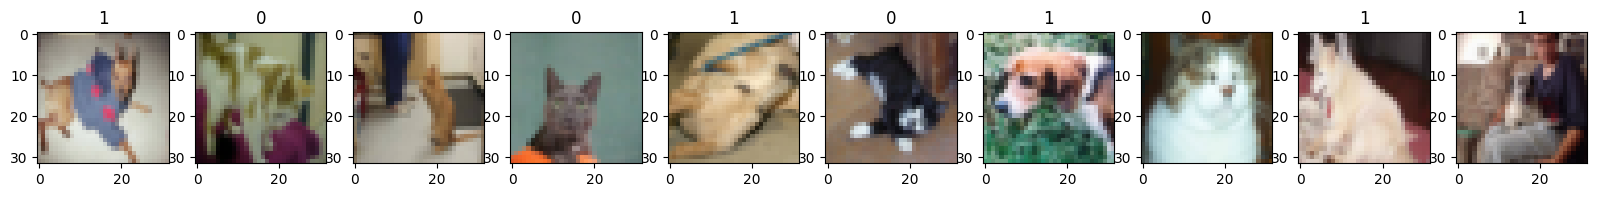

In [5]:
#plot 10 random images from image_train_datasets using subplot
fig = plt.figure(figsize=(20,20))
for i in range(10):
    idx = torch.randint(len(image_train_datasets),(1,)).item()
    img = image_train_datasets[idx][0]
    img = img.permute(1,2,0)
    fig.add_subplot(1,10,i+1)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.title(image_train_datasets[idx][1])
plt.show()


In [6]:
model = LeNet5(2)
model.to(DEVICE)
torch.compile(model)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, )

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [8]:
import torchsummary
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              ReLU-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
       BatchNorm2d-6           [-1, 16, 10, 10]              32
              ReLU-7           [-1, 16, 10, 10]               0
         MaxPool2d-8             [-1, 16, 5, 5]               0
            Linear-9                  [-1, 120]          48,120
             ReLU-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
           Linear-13                    [-1, 2]             170
Total params: 61,370
Trainable params: 

In [9]:
if not os.path.isdir("./runs"):
    os.mkdir("./runs")
    
#run id is date and time of the run
run_id = time.strftime("%Y-%m-%d_%H-%M-%S")

#create folder for this run in runs folder
os.mkdir("./runs/" + run_id)

save_dir = "./runs/" + run_id

results = engine.trainer(model, train_dataloaders, val_dataloaders, criterion, optimizer, DEVICE, EPOCHS, save_dir)


Epoch 1:


100%|██████████| 79/79 [03:26<00:00,  2.61s/it]


Train Loss: 0.6483, Train Acc: 0.6249


100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


Val Loss: 0.6059, Val Acc: 0.6755

Epoch 2:


 39%|███▉      | 31/79 [01:13<01:52,  2.35s/it]

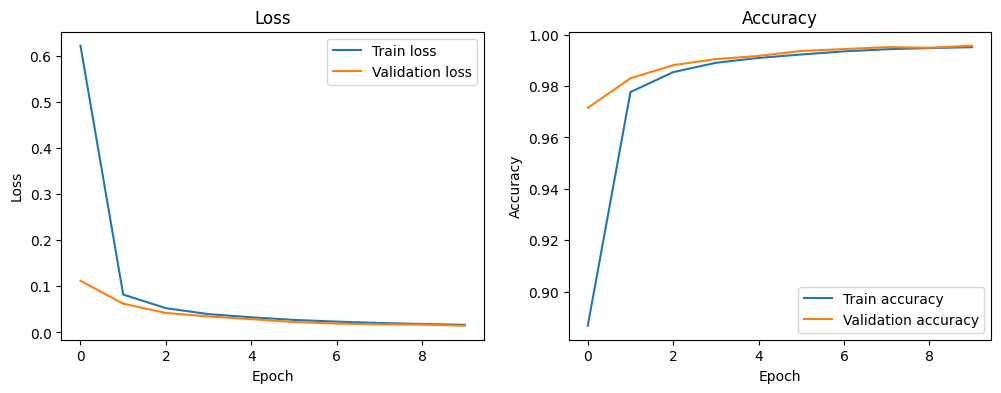

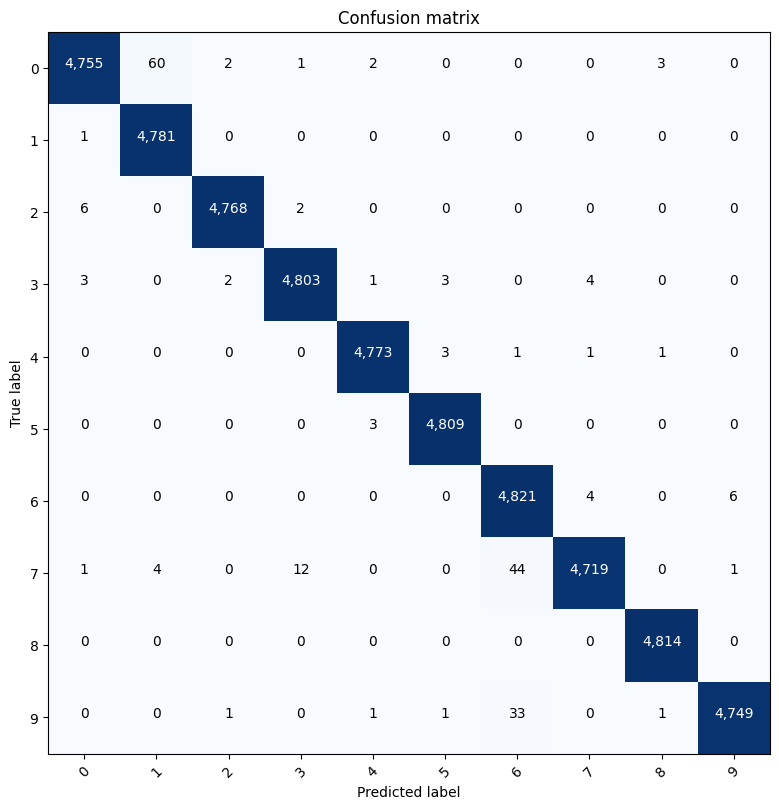

In [11]:
plot_results(results, save_dir)
plot_confussion_matrix(save_dir, model, classes=[i for i in range(10)], loader=val_dataloaders, device=DEVICE)